<a href="https://www.kaggle.com/code/agataklisko/rainfall-prediction-competition?scriptVersionId=235511880" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, f1_score, get_scorer_names
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# EDA
Let's start with loading the data set and checking basic info.

In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_file = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
test_file['winddirection'] = test_file['winddirection'].fillna(test_file['winddirection'].mean())

In [3]:
data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [5]:
data.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


All data are numeric and at the first sight there are no missing values in train set. However I found one missing value in 'winddirection' column of test_file and I decided to impute it with mean. 

There is one annoying typo in column name, so let's fix it and dive deeper into our analysis!

In [6]:
test_file['winddirection'] = test_file['winddirection'].fillna(test_file['winddirection'].mean())

In [7]:
data.rename({'temparature' : 'temperature'}, axis =1, inplace =True)
test_file.rename({'temparature' : 'temperature'}, axis =1, inplace =True)

The **'day'** variable has numbers between 1 and 365, what indicates days of the year across 6 years. Categorical feature with names of the months might be more useful, allowing us to check seasonality. However, there is a bias in data. Each number of a day should be present in the data exactly 6 times, but there are 33 values that occur 7 times and 33 values occurring 5 times. It is very unlikely that exactly 33 days were omitted during data collection and 33 observations were taken outside scope of 6 years. I assume it is a mistake made during data entering process and I decided to fix it using indices numbers.

In [8]:
day_counts = data['day'].value_counts().to_frame()
day_counts[day_counts['count']!=6].value_counts()

count
5        34
7        34
Name: count, dtype: int64

In [9]:
for i in data.index:
   if (i+1 - data.loc[i, 'day'])%365 != 0:
       data.loc[i, 'day'] = np.where((i+1)%365 ==0, 365, ((i+1)%365) )

data['day'].value_counts()

day
1      6
252    6
250    6
249    6
248    6
      ..
121    6
120    6
119    6
118    6
365    6
Name: count, Length: 365, dtype: int64

In [10]:
test_file['day'].value_counts()

day
1      2
252    2
250    2
249    2
248    2
      ..
121    2
120    2
119    2
118    2
365    2
Name: count, Length: 365, dtype: int64

After correction, we can confirm that all number of days in the train set occur exactly 6 times and there is no need to fix test_file. Now we can divide values into 12 bins corresponding to the months.  



In [11]:
data['month'] = pd.cut(data['day'], bins = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 366], labels = np.arange(1, 13))
test_file['month'] = pd.cut(test_file['day'], bins = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 366], labels = np.arange(1, 13))

Another numeric feature that might be more useful as categorical is 'winddirection', which describes the angle from which the wind is blowing. There are 35 different values in the column, some of them appear only once. I decided to divide them into 16 categories traditionally used in weather forecasts, using the intervals found on the internet. 

After that, I drop features that are encoded in other columns and no longer needed - 'winddirection' and ''day.

In [12]:
data['winddirection'].nunique()

35

In [13]:
bins = [0, 11, 33, 56, 78, 101, 123, 146, 168, 191, 213, 236, 258, 281, 303, 326, 348, 360]
directions = ['N','NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
data['wind_dir'] = pd.cut(data['winddirection'], bins = bins, labels = directions, ordered = False)
data.drop(['winddirection', 'day'], axis = 1, inplace = True)
#
test_file['wind_dir'] = pd.cut(test_file['winddirection'], bins = bins, labels = directions, ordered = False)
test_file.drop(['winddirection', 'day'], axis = 1, inplace = True)


After some research, I found out that changes in some of the weather parameters (pressure, temperature, amount of cloud) might be useful in rainfall predictions. Let's create features describing daily changes in both train data set and test_file. 



In [14]:
data['pressure_ch'] = data['pressure'] - data['pressure'].shift(1)
data['dewpoint_ch'] = data['dewpoint'] - data['dewpoint'].shift(1)
data['cloud_ch'] = data['cloud'] - data['cloud'].shift(1)
data['sunshine_ch'] = data['sunshine'] - data['sunshine'].shift(1)
data['cloud_ch'].fillna(data['cloud_ch'].mean(), inplace = True)
data['sunshine_ch'] = data['sunshine_ch'].fillna(data['sunshine_ch'].mean())
data['dewpoint_ch'] = data['dewpoint_ch'].fillna(data['dewpoint_ch'].mean())
data['pressure_ch'] = data['pressure_ch'].fillna(data['pressure_ch'].mean())
data

,id,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,rainfall,month,wind_dir,pressure_ch,dewpoint_ch,cloud_ch,sunshine_ch
0,0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,17.2,1,1,ENE,-0.001645,-0.00064,0.0,-0.000046
1,1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,21.9,1,1,NE,2.100000,-4.00000,3.0,-1.100000
2,2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,18.1,1,1,ENE,4.600000,-6.10000,-44.0,8.300000
3,3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,35.6,1,1,ENE,-10.700000,7.50000,48.0,-8.300000
4,4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,24.8,0,1,NE,8.400000,-7.20000,-50.0,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,22.1,1,12,NE,-1.200000,2.20000,0.0,0.100000
2186,2186,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,35.3,1,12,NE,-2.200000,-4.60000,0.0,-0.100000
2187,2187,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,32.9,1,12,NE,0.900000,-2.70000,-9.0,5.000000
2188,2188,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,18.0,1,12,NE,9.000000,2.10000,14.0,-4.900000


In [15]:
test_file['pressure_ch'] = test_file['pressure'] - test_file['pressure'].shift(1)
test_file['dewpoint_ch'] = test_file['dewpoint'] - test_file['dewpoint'].shift(1)
test_file['cloud_ch'] = test_file['cloud'] - test_file['cloud'].shift(1)
test_file['sunshine_ch'] = test_file['sunshine'] - test_file['sunshine'].shift(1)
test_file['cloud_ch'].fillna(test_file['cloud_ch'].mean(), inplace = True)
test_file['sunshine_ch'] = test_file['sunshine_ch'].fillna(test_file['sunshine_ch'].mean())
test_file['pressure_ch'] = test_file['pressure_ch'].fillna(test_file['pressure_ch'].mean())

# Visual exploration of data
Let's start with some visual explorations of our dataset. First, we can see that the distribution of response variable is unbalanced, with around 75% of the observations belonging to positive class.

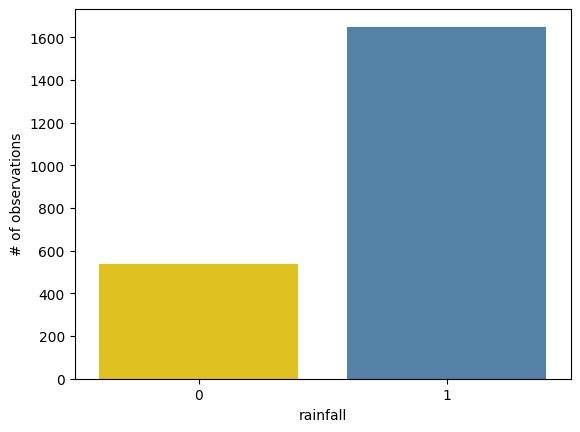

In [16]:
colors = ['gold', 'steelblue']
sns.countplot(x = 'rainfall', data = data, palette=colors)
plt.xlabel('rainfall')
plt.ylabel('# of observations')
plt.show()

Let's check if the amount of rainy days is equal among all months. That's interesting! It seems that there is some **seasonality**, with the highest number of rainy days in April and lowest in July.

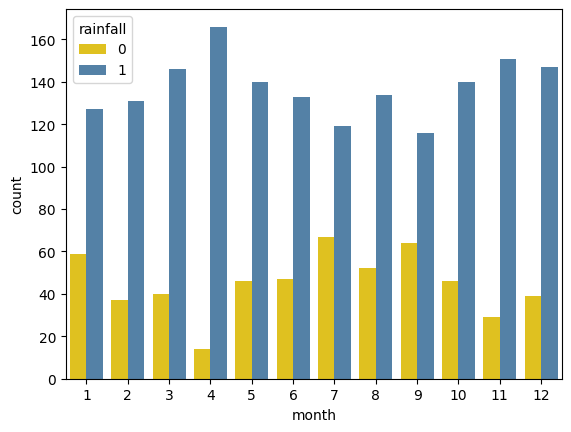

In [17]:
sns.countplot(x='month', hue = 'rainfall', data = data, palette=colors)
plt.show()

What about the wind directions? 

It seems that rain is less likely when the wind is N, W, ESE and WSW, but these directions are not very frequent.

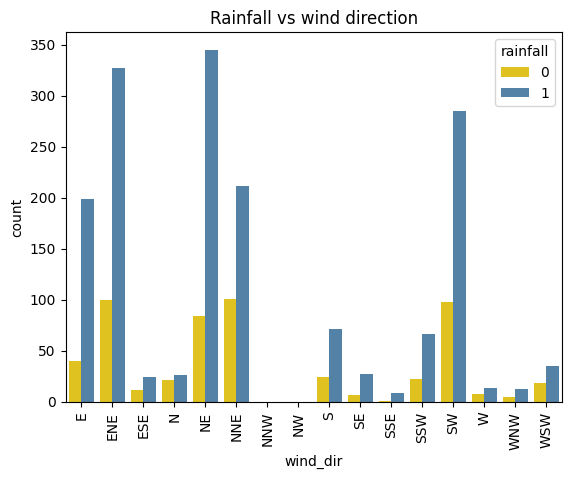

In [18]:
sns.countplot(x = data.wind_dir, hue = data['rainfall'], palette = colors)
plt.xticks(rotation = 90)
plt.title('Rainfall vs wind direction')
plt.show()

Now let's check if numeric features follow the same patterns in rainy and not rainy days. 

It seems that there is no bigger difference in 'pressure' and all features describing temperature, but 'cloud' and 'humidity' values are higher on rainy days and 'sunshine' is lower. 

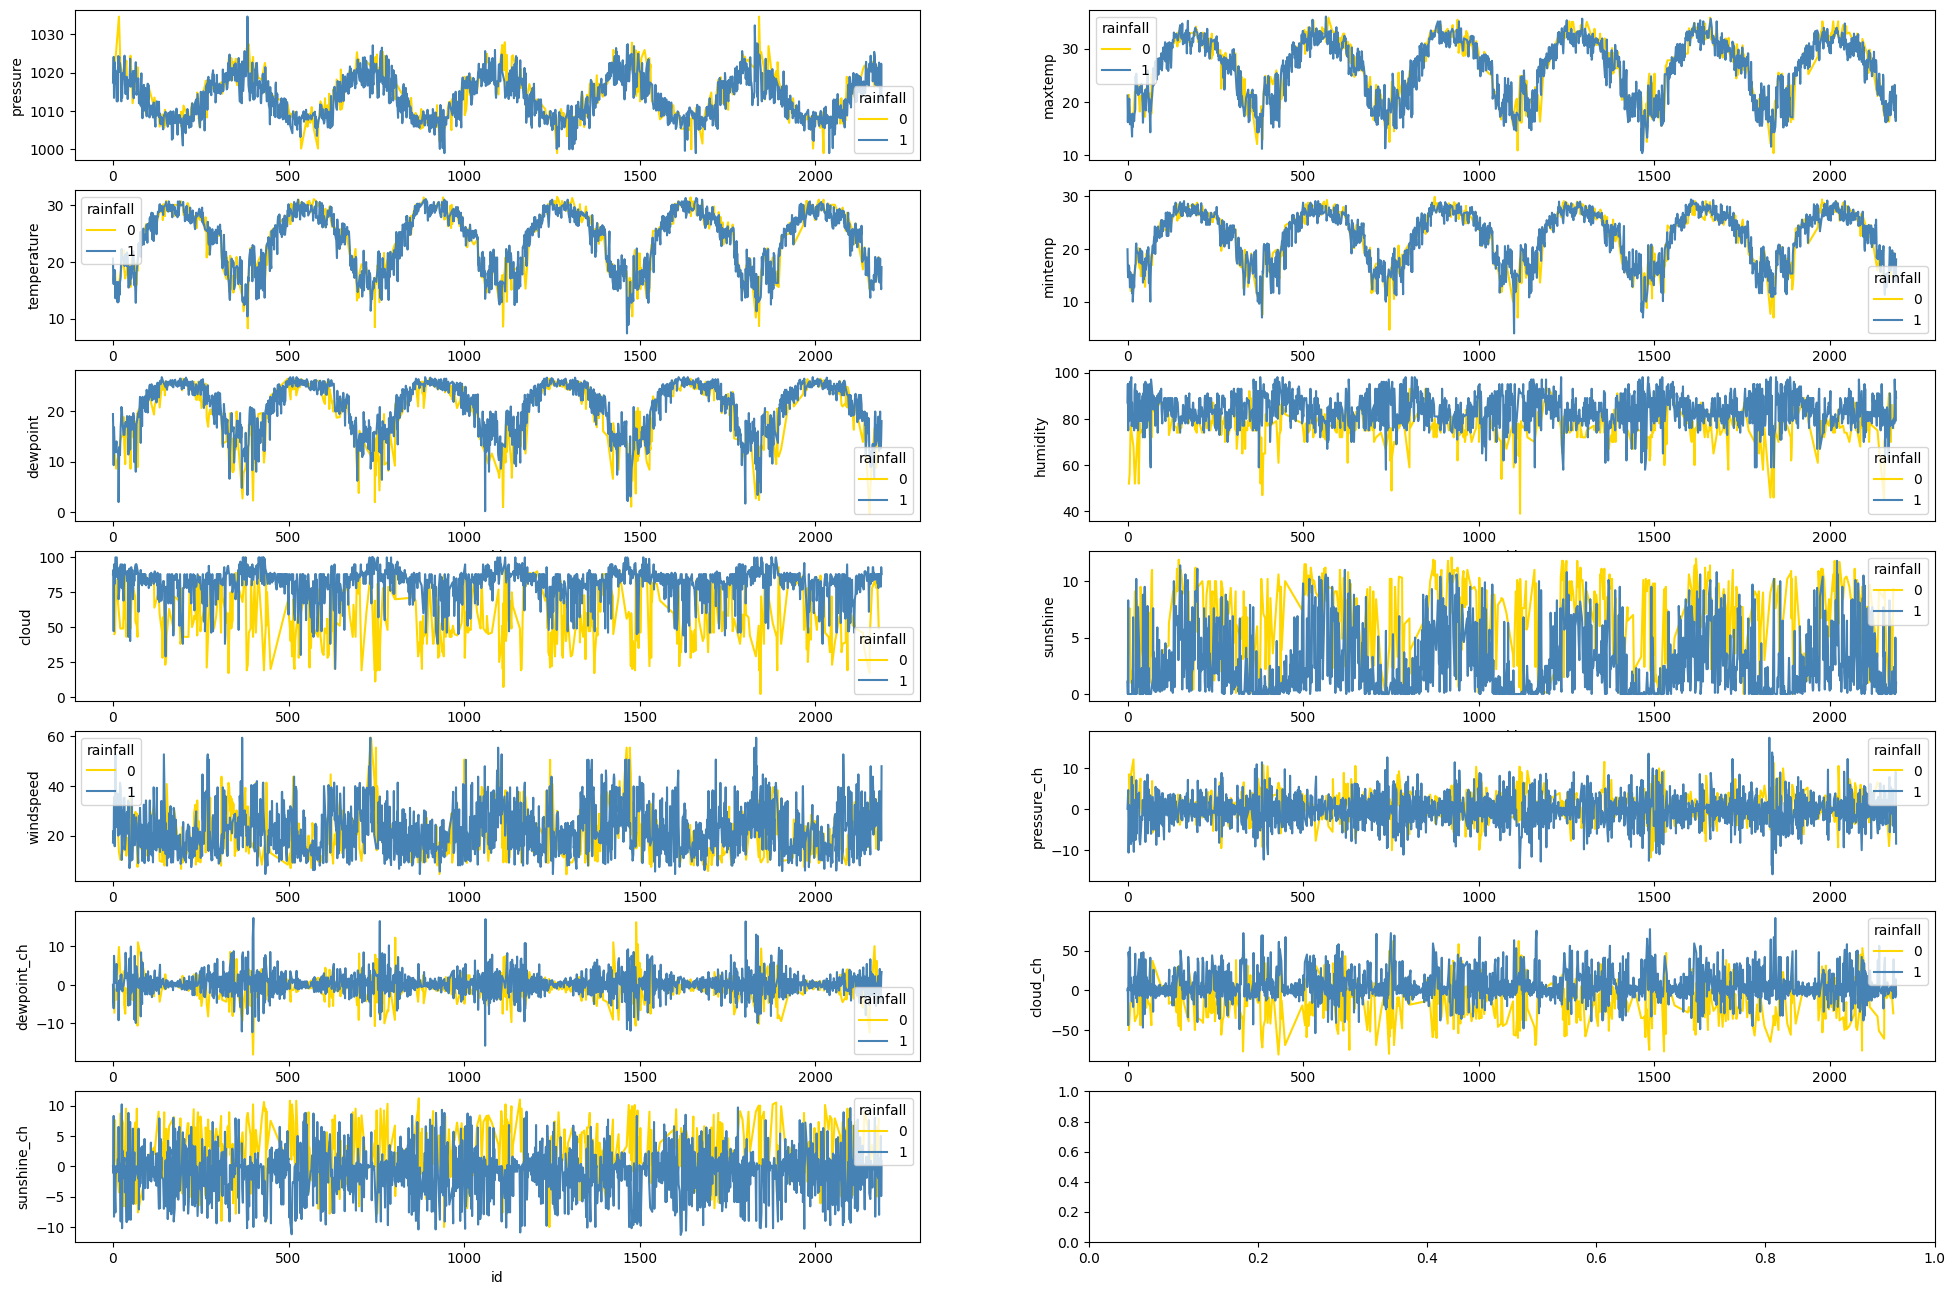

In [19]:
fig, axes = plt.subplots(7, 2, figsize = (24,16) )
axes = axes.flatten()[:-1]
for loc, ax in enumerate(axes):
    sns.lineplot(x = 'id', y = data.drop(['id', 'rainfall', 'month', 'wind_dir'], axis = 1).columns[loc], data = data, hue = 'rainfall', ax=ax, palette = colors)
plt.show()

Now let's check the **correlation** between features.

The heatmap shows that there are highly correlated features connected with temperature. Many models assume independence of features, so this might have high influence on models' predictions.

There is no high linear correlation between the response variable and any of the features. 'Rainfall' has only mild correlation with 'cloud' and 'sunshine'.

<Axes: >

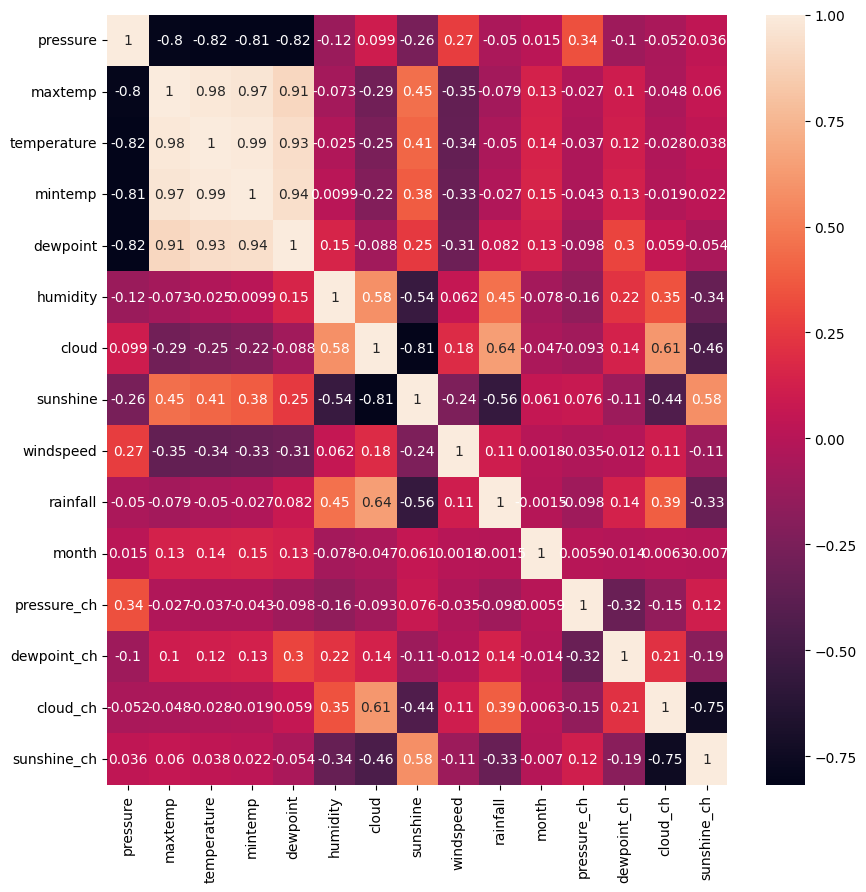

In [20]:
correlation = data.drop(['id', 'wind_dir'], axis =1).corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation, annot = True, ax = ax)

We can also see the difference in distribution of some variables, when divided into rainy and not rainy days. IQR of humidity, cloud and sunshine almost do not overlap, however there are quite a lot of outliers. 

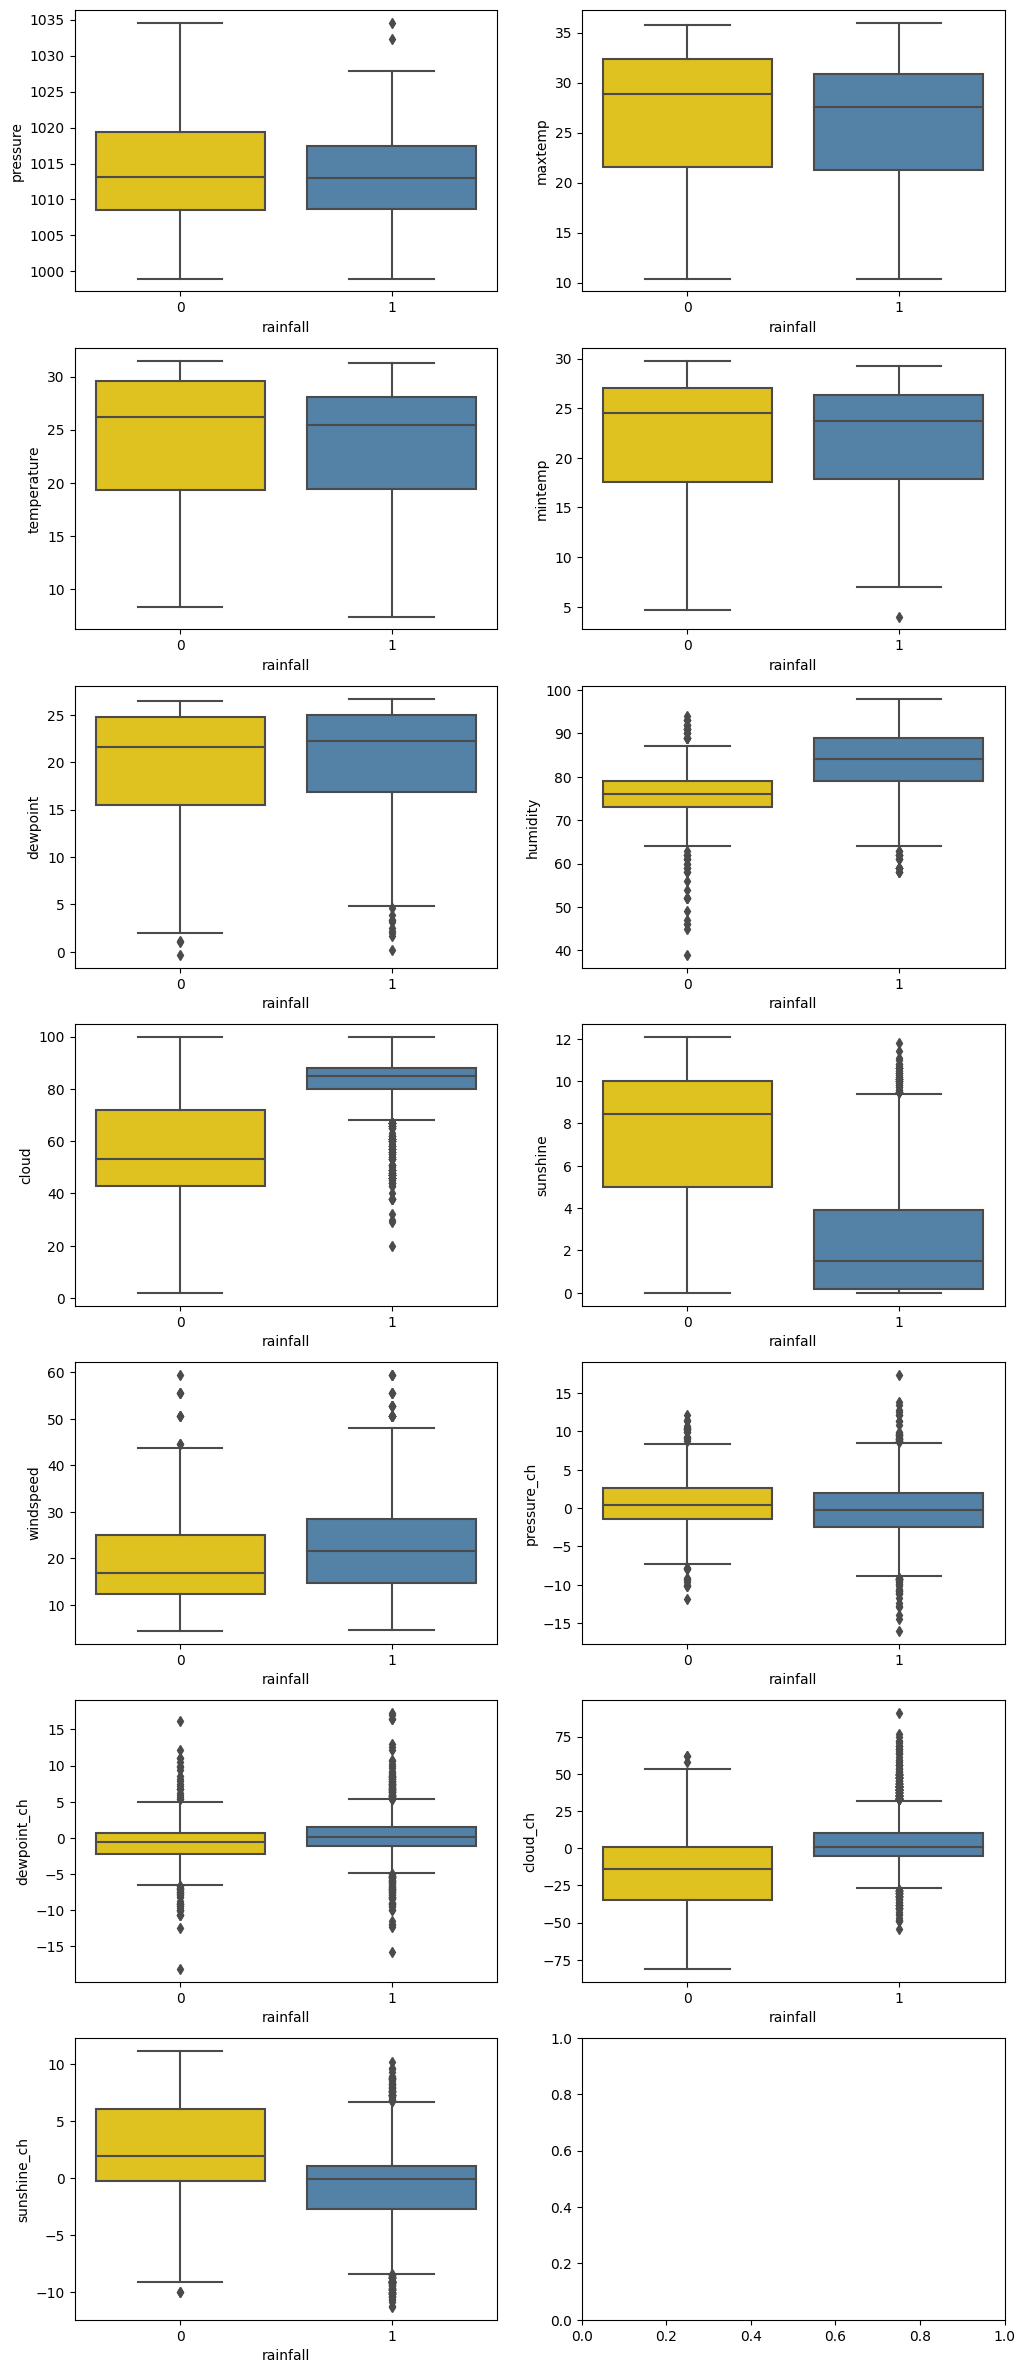

In [21]:
fig, axes = plt.subplots(7, 2, figsize = (12,30) )
axes = axes.flatten()[:-1]
for loc, ax in enumerate(axes):
    sns.boxplot(y = data.drop(['id', 'rainfall', 'wind_dir', 'month'], axis = 1).columns[loc], x = 'rainfall', data = data, ax = ax, palette = colors)
plt.show()

As the last step of our visual analysis let's check the distribution of numeric features using histograms. 

Negative skewness is visible in all features describing temperature, 'humidity' and 'cloud'.
Positive skewness is visible in 'sunshine' and 'windspeed'. 

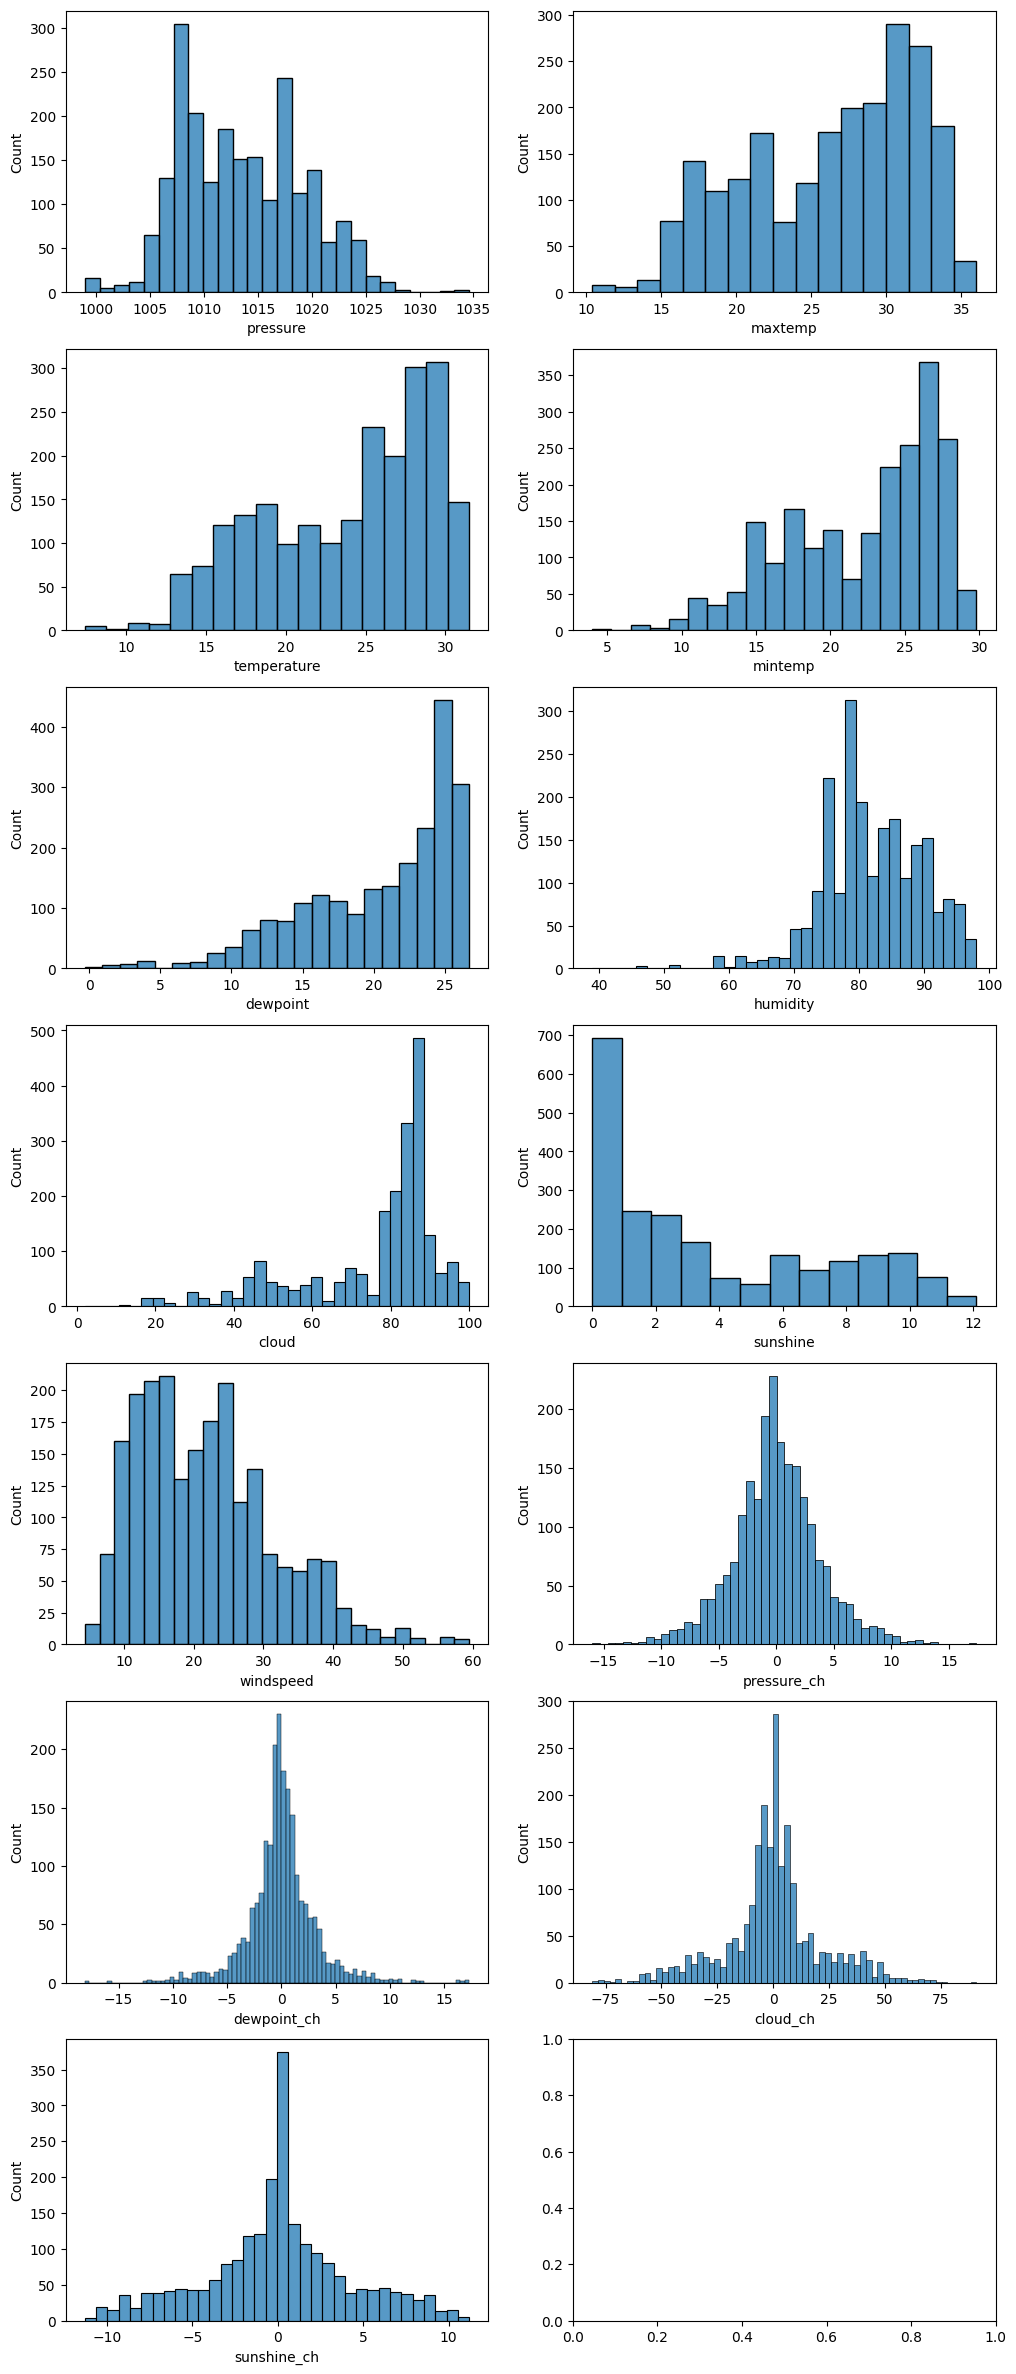

In [22]:
fig, axes = plt.subplots(7, 2, figsize = (12,30) )
axes = axes.flatten()[:-1]
for loc, ax in enumerate(axes):
    sns.histplot(x = data.drop(['id', 'month', 'rainfall', 'wind_dir'], axis = 1).columns[loc], data = data, ax = ax)
plt.show()

Let's explore skewness some more. We can see high skewness in 'cloud' and 'dewpoint' variables and moderate in 'windspeed', 'temperature' and 'sunshine'.

Outliers and skewness might result in 'squishing' data too much, while scaling for some of our models. 

It might be good to check if transformation of the data before scaling improve performance of our models.

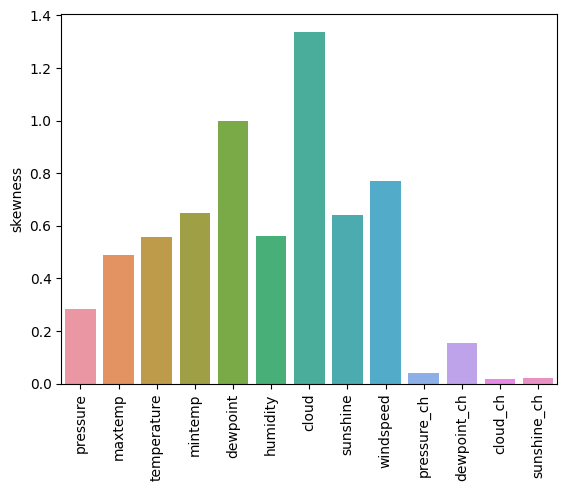

In [23]:
from scipy.stats import skew
cols = []
skews = []
for col in data.select_dtypes(include = ['float']).columns:
    cols.append(col)
    skews.append(skew(data[col]))

ax = sns.barplot(x = cols, y = np.abs(skews))
ax.set_ylabel('skewness')
plt.xticks(rotation = 90)
plt.show()

# Logistic Regression

Let's start with the simplest binary classification model - **logistic regression**. Data preparation include:
* creating dummy variables for categorical features wind_dir and month
* feature scaling with standard scaler
* creating polynomial features to catch non-linear relationships in data. 



Next, I split data into train and test sets. 

In [24]:
data_encoded = pd.get_dummies(data, columns = ['wind_dir', 'month'])
data_encoded.drop(['id'], axis = 1, inplace = True)


In [25]:
y = data_encoded[['rainfall']]
X = data_encoded.drop('rainfall', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22, shuffle = True, stratify = y)

In [26]:
lr = LogisticRegression(max_iter = 5000, class_weight = 'balanced')
poly = PolynomialFeatures()
ss = StandardScaler()
lr_pipe = Pipeline(steps = [('poly', poly),
                            ('ss', ss),
                            ('lr', lr)])
lr_params = [{'poly__degree':[1,2],
           'lr__penalty' : ['l1', 'l2'],
           'lr__C' : [0.05, 0.072, 0.075, 0.1],
            'lr__solver' : ['lbfgs','newton-cg','liblinear','saga']
          }]

lr_search = GridSearchCV(lr_pipe, lr_params, cv = 5, scoring = 'f1_weighted')
#grid search is commented out to avoid time consuming fitting every time the notebook is running
#lr_search.fit(X_train, y_train.values.ravel())
#lr_search.best_params_

GridSearchCV was used to find the best hyperparameters for Logistic Regression model. The grid search itself is commented out, because it's very time-consuming.

In [27]:
#model with hyperparamteters found in the grid
lr_grid = LogisticRegression(max_iter = 5000, class_weight = 'balanced', C=0.075,
                   penalty='l1', solver='saga')

poly_grid = PolynomialFeatures(degree = 1)
ss_grid = StandardScaler()
lr_pipe_grid = Pipeline(steps = [('poly', poly_grid),
                            ('ss', ss_grid),
                            ('lr', lr_grid)])
lr_pipe_grid.fit(X_train, y_train.values.ravel())




Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.075, class_weight='balanced',
                                    max_iter=5000, penalty='l1',
                                    solver='saga'))])

Let's define a simple function that will help us evaluate performance of each trained model and use it to compare outcome for the train and test sets.

In [28]:
def model_eval(model, X_test, y_test):
    """prints roc auc score and classification report of the fitted model"""
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    roc_auc = roc_auc_score(y_test, proba)
    class_report = classification_report(y_test, pred)
    print(f'roc_auc_score = {roc_auc} ')
    print(class_report)


In [29]:
print('Metrics of the test set:')
model_eval(lr_pipe_grid, X_test, y_test)

Metrics of the test set:
roc_auc_score = 0.8974186307519642 
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       162
           1       0.93      0.87      0.90       495

    accuracy                           0.85       657
   macro avg       0.80      0.83      0.81       657
weighted avg       0.86      0.85      0.86       657



In [30]:
print('Metrics of the train set:')
model_eval(lr_pipe_grid, X_train, y_train)

Metrics of the train set:
roc_auc_score = 0.8999450285164571 
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       378
           1       0.93      0.86      0.89      1155

    accuracy                           0.85      1533
   macro avg       0.79      0.83      0.81      1533
weighted avg       0.86      0.85      0.85      1533



The performance of the model is similar for train and test sets, so there is no overfitting. We achieve the ROC AUC score of almost 0.9 for the test set, what is quite good outcome for first, simple model.